In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
data_dir = r"C:\Users\kavi0\Downloads\archive (3)\flowers"
img_size = 128
X, y = [], []
labels = os.listdir(data_dir)

In [3]:
for idx, label in enumerate(labels):
    folder = os.path.join(data_dir, label)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        try:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)
        except:
            pass

In [4]:
X = np.array(X) / 255.0
y = to_categorical(y, num_classes=len(labels))
print("✅ Dataset loaded successfully!")
print("Total images:", X.shape[0])
print("Classes:", labels)

✅ Dataset loaded successfully!
Total images: 15740
Classes: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print("✅ Dataset split into training and testing sets.")
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


✅ Dataset split into training and testing sets.
Training set size: 12592
Testing set size: 3148


In [6]:
datagen = ImageDataGenerator(rotation_range=25,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, y_test))


In [8]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model(r"C:\7Th sem\Deep Learning\mini project\plant_name_detector.h5")
print("✅ Model loaded successfully!")

# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Model Accuracy on Test Set: {acc*100:.2f}%")


✅ Model loaded successfully!
99/99 [==============================] - 14s 109ms/step - loss: 0.7434 - accuracy: 0.7503
✅ Model Accuracy on Test Set: 75.03%


In [9]:
#plt.figure(figsize=(8, 4))
#plt.plot(history.history['accuracy'], label='Train')
#plt.plot(history.history['val_accuracy'], label='Validation')
#plt.title('Training Accuracy')
#plt.legend()
#plt.show()


In [10]:
model.save("plant_name_detector.h5")
print("✅ Model saved as plant_name_detector.h5")


✅ Model saved as plant_name_detector.h5


In [11]:
botanical_path = r"C:\7Th sem\Deep Learning\mini project\botanical.xlsx"
botanical_df = pd.read_excel(botanical_path)

def get_botanical_info(flower_name):
    row = botanical_df[botanical_df['Common Name'].str.lower() == flower_name.lower()]
    if not row.empty:
        info = row.iloc[0]
        print("\n📖 Botanical Information:")
        print(f"Common Name: {info['Common Name']}")
        print(f"Botanical Name: {info['Botanical Name']}")
        print(f"Family: {info['Family']}")
        print(f"Type: {info['Type']}")
        print(f"Uses / Significance: {info['Uses / Significance']}")
    else:
        print("\n⚠️ Botanical information not found for this flower.")


In [12]:
import seaborn as sns

def plot_top3(predictions, labels):
    top_indices = predictions.argsort()[-3:][::-1]
    top_probs = predictions[top_indices]*100
    top_labels = [labels[i] for i in top_indices]

    plt.figure(figsize=(6,4))
    sns.barplot(x=top_probs, y=top_labels, palette="viridis")
    plt.xlabel("Confidence (%)")
    plt.title("Top 3 Predictions")
    plt.xlim(0, 100)
    plt.show()

    return top_indices


In [13]:
def grad_cam(model, img_array, last_conv_layer_name='conv2d_2'):
    # Ensure input shape: (1, img_size, img_size, 3)
    img_array = np.expand_dims(img_array, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_class = tf.argmax(predictions[0])
        loss = predictions[:, top_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-10)  # normalize

    # Convert to 0-255 and uint8
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img_size, img_size))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    return heatmap


In [14]:
import tensorflow as tf
def predict_image_explain(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Image not found at: {img_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img_rgb, (img_size, img_size))
    input_img = np.expand_dims(resized, axis=0) / 255.0

    predictions = model.predict(input_img)[0]
    top_indices = predictions.argsort()[-3:][::-1]

    predictions = model.predict(input_img)[0]
    top_indices = plot_top3(predictions, labels)  # Bar chart

    top1 = labels[top_indices[0]]
    confidence = predictions[top_indices[0]] * 100
    print(f"\n🌼 Predicted Flower: {top1} ({confidence:.2f}%)")

    get_botanical_info(top1)  # Botanical info

    # Grad-CAM
    heatmap = grad_cam(model, resized)
    superimposed_img = cv2.addWeighted(resized, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {top1} ({confidence:.2f}%)", fontsize=16)
    #plt.title(f"Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Overlay")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 61ms/step


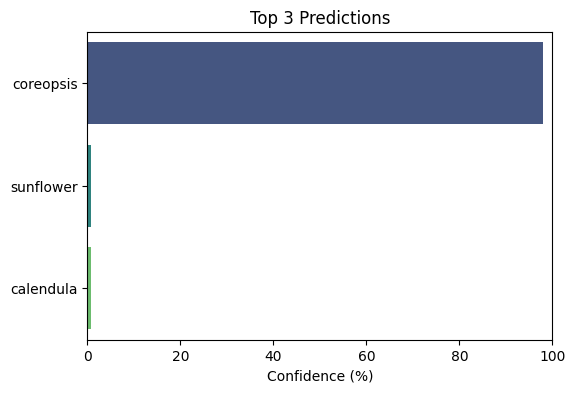


🌼 Predicted Flower: coreopsis (97.92%)

📖 Botanical Information:
Common Name: coreopsis
Botanical Name: Coreopsis lanceolata
Family: Asteraceae
Type: Perennial
Uses / Significance: Ornamental plant; attracts pollinators; symbolizes cheerfulness.


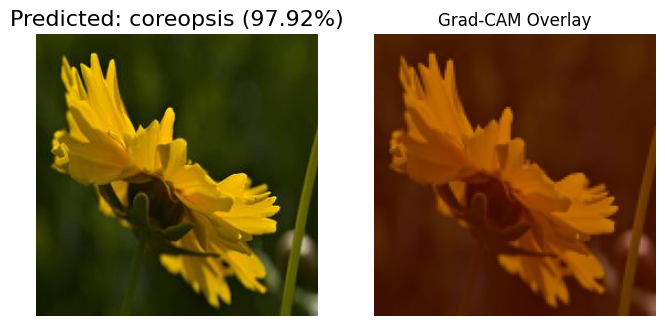

In [15]:
predict_image_explain(r"C:\Users\kavi0\Downloads\archive (3)\flowers\coreopsis\152836377_a990f2023f_c.jpg")


In [24]:
import seaborn as sns
import glob
from IPython.display import display, Markdown

def predict_image_explain(path):
    # If a folder path is given → get all image files inside
    if os.path.isdir(path):
        image_files = glob.glob(os.path.join(path, "*.*"))
        print(f"📂 Found {len(image_files)} images in folder.")
        for img_path in image_files[:5]:   # limit to first 5
            predict_image_explain(img_path)
        return

    # Read image
    img = cv2.imread(path)
    if img is None:
        print(f"⚠️ Image not found at: {path}")
        return

    # Preprocess
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img_rgb, (img_size, img_size))
    input_img = np.expand_dims(resized, axis=0) / 255.0

    # Predict
    predictions = model.predict(input_img)[0]
    top_indices = predictions.argsort()[-3:][::-1]
    top1 = labels[top_indices[0]]
    confidence = predictions[top_indices[0]] * 100

    # 🌸 Display predicted result
    display(Markdown(f"### 🌼 Predicted Flower: **{top1} ({confidence:.2f}%)**"))

    # 📊 Display top 3 as bar chart
    top3_labels = [labels[i] for i in top_indices]
    top3_probs = [predictions[i]*100 for i in top_indices]
    sns.barplot(x=top3_probs, y=top3_labels, palette="viridis")
    plt.xlabel("Confidence (%)")
    plt.title("Top 3 Predictions")
    plt.xlim(0, 100)
    plt.show()

    # 🖼️ Show image
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {top1} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    # 📖 Botanical Info
    row = botanical_df[botanical_df['Common Name'].str.lower() == top1.lower()]
    if not row.empty:
        info = row.iloc[0]
        display(Markdown(f"""
        🌿 Botanical Information:
        Common Name:{info['Common Name']}
        Botanical Name:{info['Botanical Name']}
        Family:{info['Family']}
        Type: {info['Type']}
        Uses / Significance: {info['Uses / Significance']}
        """))
    else:
        print("⚠️ Botanical information not found for this flower.")

    print("-" * 60)
    


📂 Found 4 images in folder.
1/1 [==============================] - 0s 61ms/step


### 🌼 Predicted Flower: **magnolia (80.21%)**

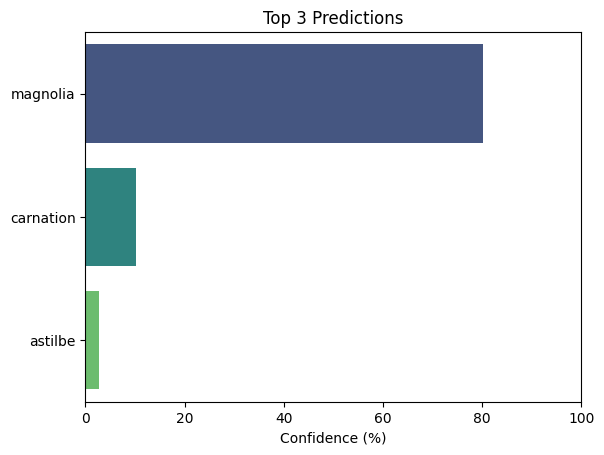

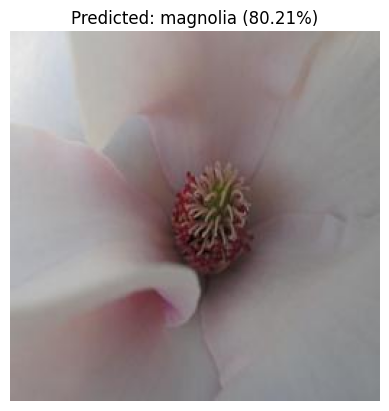


        🌿 Botanical Information:
        Common Name:magnolia
        Botanical Name:Magnolia grandiflora
        Family:Magnoliaceae
        Type: Tree
        Uses / Significance: Ornamental; used in herbal medicine and perfumes.
        

------------------------------------------------------------
1/1 [==============================] - 0s 69ms/step


### 🌼 Predicted Flower: **sunflower (99.90%)**

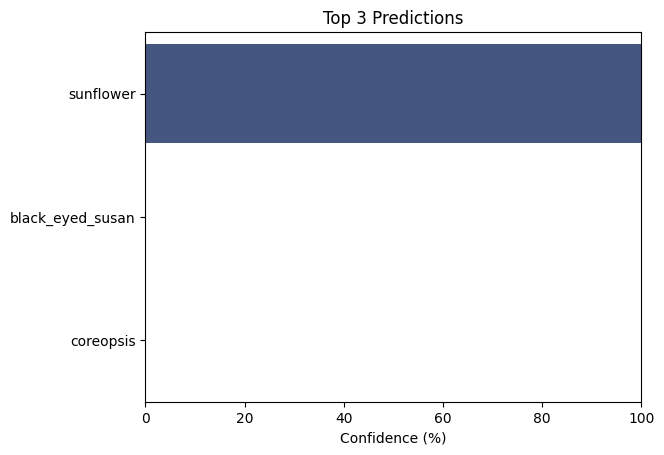

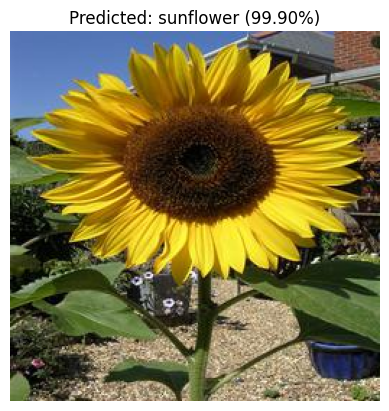


        🌿 Botanical Information:
        Common Name:sunflower
        Botanical Name:Helianthus annuus
        Family:Asteraceae
        Type: Annual
        Uses / Significance: Source of sunflower oil and seeds; follows the sun (heliotropism).
        

------------------------------------------------------------
1/1 [==============================] - 0s 60ms/step


### 🌼 Predicted Flower: **water_lily (49.77%)**

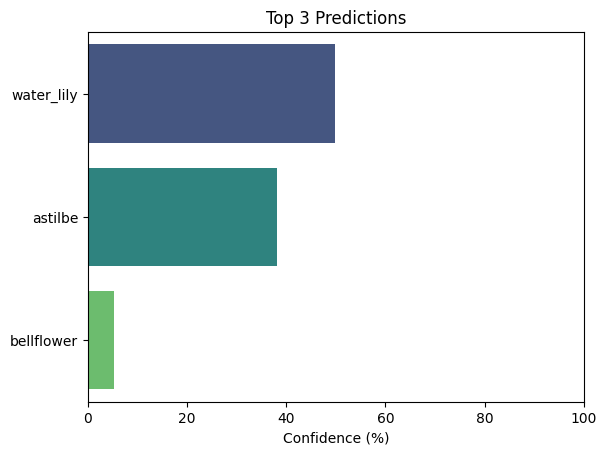

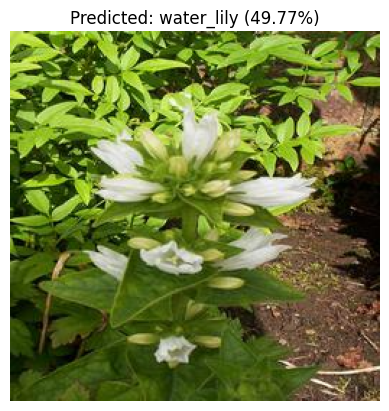


        🌿 Botanical Information:
        Common Name:water_lily
        Botanical Name:Nymphaea alba
        Family:Nymphaeaceae
        Type: Aquatic Perennial
        Uses / Significance: Ornamental; symbolizes purity; used in ponds and gardens.
        

------------------------------------------------------------
1/1 [==============================] - 0s 86ms/step


### 🌼 Predicted Flower: **water_lily (85.84%)**

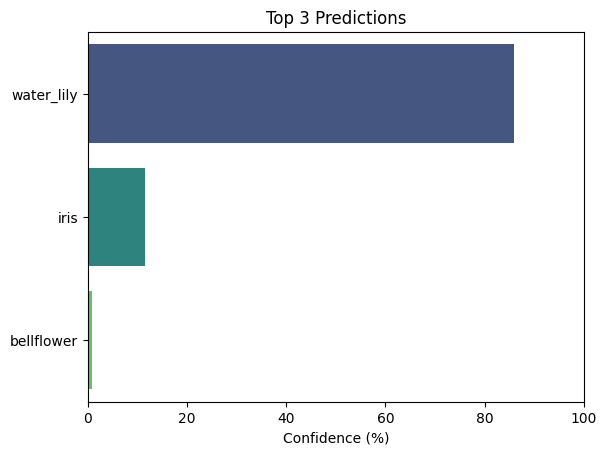

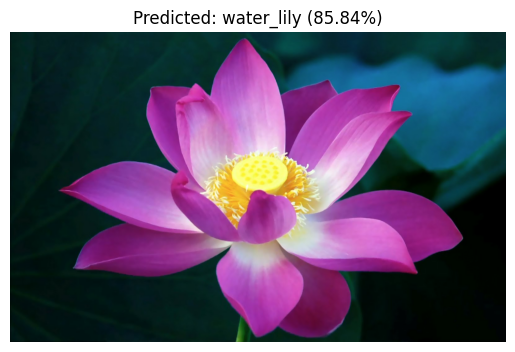


        🌿 Botanical Information:
        Common Name:water_lily
        Botanical Name:Nymphaea alba
        Family:Nymphaeaceae
        Type: Aquatic Perennial
        Uses / Significance: Ornamental; symbolizes purity; used in ponds and gardens.
        

------------------------------------------------------------


In [25]:
predict_image_explain(r"C:\7Th sem\Deep Learning\flowers")
